In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

seed = 1234
np.random.seed(seed)

In [4]:
df = pd.read_csv('data/humsavar_dbnsfp53_complete.csv')

## preprocessing the data

# represent "ref" and "alt" cols in one "mutation" col
# map "mutation" col to numbers
df['mutation'] = df['ref'] + df['alt']
df = pd.get_dummies(df, columns=["mutation"], drop_first=False)

# encode chromosomes ('X' and 'Y')
chrom_mapping = {
    **{str(i): i for i in range(1, 23)},  # "1"–"22"
    "X": 23,
    "Y": 24
}
df["chr"] = df["chr"].map(chrom_mapping)

# encode labels
df['Label'] = df['Label'].map({'Pathogenic': 1, 'Benign': 0})

# encode SIFT, PolyPhen predictions
df = pd.get_dummies(df, columns=['SIFT_pred', 'Polyphen2_HDIV_pred'], drop_first=False)

# remove unnecessary columns
drop_cols = ['Gene', 'Entry', 'FTId', 'AA_change', 'Category',
             'dbSNP', 'Disease', 'rs_dbSNP', 'ref', 'alt']
df = df.drop(columns=drop_cols)


X = df.drop(columns=["Label"])
Y = df["Label"]

df.head()


,Label,chr,pos,SIFT_score,Polyphen2_HDIV_score,CADD_raw,CADD_phred,REVEL_score,mutation_AC,mutation_AG,...,mutation_GC,mutation_GT,mutation_TA,mutation_TC,mutation_TG,SIFT_pred_D,SIFT_pred_T,Polyphen2_HDIV_pred_B,Polyphen2_HDIV_pred_D,Polyphen2_HDIV_pred_P
0,1,1,93998027,0.049,0.765,4.435338,25.30,0.860,False,True,...,False,False,False,False,False,True,False,False,False,True
1,0,1,93998061,0.053,0.975,2.412747,18.61,0.503,False,False,...,False,False,False,False,False,False,True,False,True,False
2,0,1,93998061,0.268,0.061,1.492491,14.14,0.313,False,False,...,False,False,False,False,False,False,True,True,False,False
3,1,1,94000836,1.000,0.051,2.740497,20.10,0.577,False,False,...,False,False,False,True,False,False,True,True,False,False
4,1,1,94000866,0.000,1.000,4.731917,26.50,0.937,False,False,...,False,False,False,False,False,True,False,False,True,False


In [5]:
# split data into test and train/validation data
X_pre, Xte, Y_pre, Yte = train_test_split(
    X, Y, test_size=0.15,
    random_state=seed,
)

# split train/validation data
Xtr, Xva, Ytr, Yva = train_test_split(
    X_pre, Y_pre, test_size=0.15, 
    random_state=seed, shuffle=True
)

## Basic Decision Tree

A simple model that only predicts the majority class, "benign", would be about **70% accurate**. Here we seek to train a decision tree to have at least more than 70% accuracy by varying values for `criterion`, `max_depth`, `min_samples_leaf`, and `class_weight`.

We will use F1 score along with accuracy in evaluation to measure how well our models are at avoding false negatives (low recall) and false positives (low precision).

In [6]:
DT = DecisionTreeClassifier(random_state=seed)
DT.fit(Xtr, Ytr)

ytr_pred = DT.predict(Xtr)
yte_pred = DT.predict(Xte)

print("Train Accuracy:", accuracy_score(Ytr, ytr_pred))
print("Train F1 Score:", f1_score(Ytr, ytr_pred, average="macro"))
print()
print("Test Accuracy:", accuracy_score(Yte, yte_pred))
print("Test F1 Score:", f1_score(Yte, yte_pred, average="macro"))

Train Accuracy: 0.9993674089068826
Train F1 Score: 0.9992646236664163

Test Accuracy: 0.902498476538696
Test F1 Score: 0.8868061184017658


scikitlearn's default decision tree has gives us a pretty good baseline, with 90% test accuracy and 0.89 F1 score. Let's see if we can do better!

## Training on Criterion

In [8]:
criterions = ["gini", "entropy", "log_loss"]

for cri in criterions:
    DT = DecisionTreeClassifier(
        criterion=cri,
        random_state=seed
    )
    DT.fit(Xtr, Ytr)

    yva_pred = DT.predict(Xva)

    print("Criterion:", cri)
    print("Validation Accuracy:",
          accuracy_score(Yva, yva_pred))
    print("Validation F1 Score:",
          f1_score(Yva, yva_pred)) 
    print()

Criterion: gini
Validation Accuracy: 0.8974910394265233
Validation F1 Score: 0.8361970217640321

Criterion: entropy
Validation Accuracy: 0.9189964157706093
Validation F1 Score: 0.870561282932417

Criterion: log_loss
Validation Accuracy: 0.9189964157706093
Validation F1 Score: 0.870561282932417



The criterions `entropy` and `log_loss` have equal accuracy and f1 scores, which are both better than those for `gini`. We will arbitrarily select `gini`.

In [11]:
DT = DecisionTreeClassifier(
    criterion="entropy",
    random_state=seed
)
DT.fit(Xtr, Ytr)

yte_pred = DT.predict(Xte)
yva_pred = DT.predict(Xva)

print("Criterion: entropy")
print("Test Accuracy:",
        accuracy_score(Yte, yte_pred))
print("Test F1 Score:",
        f1_score(Yte, yte_pred)) 

Criterion: entropy
Test Accuracy: 0.894576477757465
Test F1 Score: 0.8338136407300673


The test accuracy and f1 scores for `entropy` are surprisingly significantly lower than the validation accuracy and f1 scores.

## Training on Max Depth

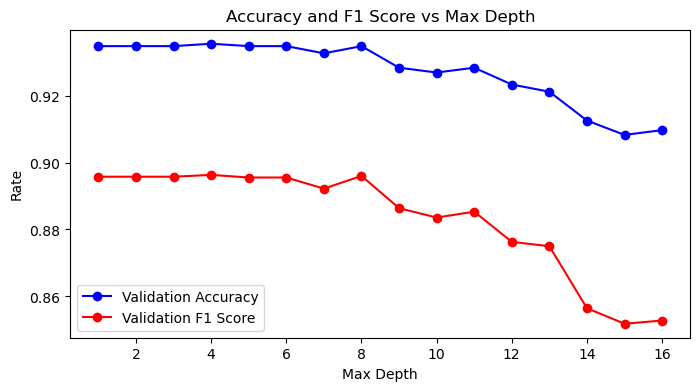

In [23]:
depths = list(range(1, 17))
accuracies = []
f1_scores = []

for d in depths:
    DT = DecisionTreeClassifier(
            criterion="entropy",
            max_depth=d, 
            random_state=seed
    )
    DT.fit(Xtr, Ytr)

    yva_pred = DT.predict(Xva)

    accuracies.append(accuracy_score(Yva, yva_pred))
    f1_scores.append(f1_score(Yva, yva_pred))
    
figure, axes = plt.subplots(1, 1, figsize=(8,4))
axes.set_title("Accuracy and F1 Score vs Max Depth")
axes.set_xlabel("Max Depth")
axes.set_ylabel("Rate")
axes.plot(depths, accuracies, 
          "bo-", label="Validation Accuracy")
axes.plot(depths, f1_scores,
          "ro-", label="Validation F1 Score")

axes.legend();

Validation accuracy and F1 score are both highest at `max_depth`=`8`.

In [18]:
DT = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=8,
    random_state=seed
)
DT.fit(Xtr, Ytr)

yte_pred = DT.predict(Xte)
yva_pred = DT.predict(Xva)

print("Test Accuracy:",
        accuracy_score(Yte, yte_pred))
print("Test F1 Score:",
        f1_score(Yte, yte_pred)) 

Test Accuracy: 0.9140767824497258
Test F1 Score: 0.863768115942029


## Training on Min Samples Leaf

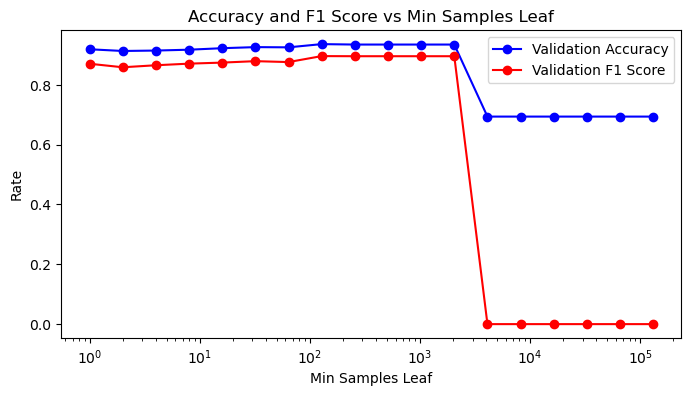

In [22]:
num_samples = [2**i for i in range(0, 18)]
accuracies = []
f1_scores = []

for n in num_samples:
    DT = DecisionTreeClassifier(
            criterion="entropy",
            max_depth=100, 
            min_samples_leaf=n,
            random_state=seed
    )
    DT.fit(Xtr, Ytr)

    yva_pred = DT.predict(Xva)

    accuracies.append(accuracy_score(Yva, yva_pred))
    f1_scores.append(f1_score(Yva, yva_pred))

figure, axes = plt.subplots(1, 1, figsize=(8,4))
axes.set_title("Accuracy and F1 Score vs Min Samples Leaf")
axes.set_xlabel("Min Samples Leaf")
axes.set_ylabel("Rate")
axes.semilogx(num_samples, accuracies, 
          "bo-", label="Validation Accuracy")
axes.semilogx(num_samples, f1_scores,
          "ro-", label="Validation F1 Score")

axes.legend();

Validation accuracy and F1 score are both highest at `min_samples_leaf`=`2^7`=`128`.

In [19]:
DT = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=100,
    min_samples_leaf=128,
    random_state=seed
)
DT.fit(Xtr, Ytr)

yte_pred = DT.predict(Xte)
yva_pred = DT.predict(Xva)

print("Test Accuracy:",
        accuracy_score(Yte, yte_pred))
print("Test F1 Score:",
        f1_score(Yte, yte_pred)) 

Test Accuracy: 0.9189518586227909
Test F1 Score: 0.8689655172413793


Controlling complexity with `min_samples_leaf` yielded just slightly better accuracy and F1 scores than with `max_depth`. 

## Training on Class Weight

In [24]:
DT_unwei = DecisionTreeClassifier(
    criterion="entropy",
    random_state=seed
)
DT_unwei.fit(Xtr, Ytr)

DT_wei = DecisionTreeClassifier(
    criterion="entropy",
    class_weight="balanced",
    random_state=seed
)
DT_wei.fit(Xtr, Ytr)

yva_pred_unwei = DT_unwei.predict(Xva)
yva_pred_wei = DT_wei.predict(Xva)

print("Unweighted")
print("Validation Accuracy:",
        accuracy_score(Yva, yva_pred_unwei))
print("Validation F1 Score:",
        f1_score(Yva, yva_pred_unwei)) 
print()

print("Weighted")
print("Validation Accuracy:",
        accuracy_score(Yva, yva_pred_wei))
print("Validation F1 Score:",
        f1_score(Yva, yva_pred_wei))

Unweighted
Validation Accuracy: 0.9189964157706093
Validation F1 Score: 0.870561282932417

Weighted
Validation Accuracy: 0.8989247311827957
Validation F1 Score: 0.8399545970488081


Since we have abundantly more "benign" than "pathogenic" points in our data, we expected that weighting the results from training on the fewer "pathogenic" points would result in improved scores. However, no weighting proved to be better.

## Conclusion

We combine our results to train a final decision tree model.

In [ ]:
DT = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=100,
    min_samples_leaf=128,
    random_state=seed
)
DT.fit(Xtr, Ytr)

yte_pred = DT.predict(Xte)
yva_pred = DT.predict(Xva)

print("Test Accuracy:",
        accuracy_score(Yte, yte_pred))
print("Test F1 Score:",
        f1_score(Yte, yte_pred))

Test Accuracy: 0.9189518586227909
Test F1 Score: 0.8689655172413793


Our final model interestingly has a higher test accuracy, but lower F1 score, than the default decision tree classifier from `scikitlearn`.

Since we set `min_samples_leaf` to a relatively large value, `128`, our model is likely ***underfitting*** the data. For further training, we could test different parameters provided by the `DecisionTreeClassifier`. We could also score our model with **ROC-AUC** and **PR-AUC**, along with **confusion matrixes** for greater insight into what kind of errors our models make.